#  NLP_ENDOPATHS_Nicolai

Author: Nicolai Wolpert
Email: nicolai.wolpert@capgemini.com
Date: June 2024

## Imports

In [1]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
from matplotlib import pyplot as plt
import seaborn as sns
#import eli5 # eli5 not working anymore for current stable version of sklearn
from IPython.display import display

from preprocess_NLP import from_X_split_get_Y_split
from sklearn.utils import resample, shuffle

# Utils for NLP : 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Utils for Multilabel classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, hamming_loss, accuracy_score, jaccard_score, classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import *
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import plot_tree

# Multiclass/Multilabel preparation :
from sklearn.base import BaseEstimator, ClassifierMixin

# Kfold cross-validation with stratification
from Opti_utils.ML_utils import kfold_cv_stratified

# Custom preprocessing : 
from preprocess_NLP import preprocess_and_split
from metrics_utils import *
from Opti_utils.ML_utils import Binarisation

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense


[nltk_data] Downloading package stopwords to /home/nounou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-01-24 15:22:21.164681: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 15:22:23.058717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-24 15:22:33.222113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/numpy/core/getlimits.py:542:

## Load data

In [2]:
'''
# Les features qui ont été identifiés comme les plus pertinentes pour pouvoir prédire l'endiométrose profonde sont les suivants
# (cela veut dire qu'ils donnent une sensibilité et spécificité au dessus du seuil de 0.4 et 0.5):
features_of_interest = ['age', 'atcd.endo', 'sf.dsm.eva', 'sf.dpc', 'tv.douleur.lusd', 'tv.douleur.lusg', 'chir_GD', 'chir_SW']
'''
# See 'Explore_features_ML_NLP' for how these have been identified
features_of_interest = ['atcd.endo', 'irm.lusg', 'tv.douloureux', 'irm.externe', 'sf.dig.diarrhee', 'echo.lusg', 'echo.lusd', 'ef.hormone.dpc', 'effet.hormone']
features_of_interest = ['atcd.absenteisme']
#features_of_interest = 'all'

In [3]:
# Loading X : 
df_nlp = pd.read_csv('Data/DATA_PROCESSED/donnees_entree_nlp_sans_endo.csv', usecols=['Anonymisation', 'Date', 'Nature', 'Résumé'])
print('X shape is :', df_nlp.shape)

# Use original receuil data or infos extracted manually from the gyneco files
receuil_data = 'manual_gyneco'     # 'orig', 'manual_gyneco'

# Loading Y : 
if receuil_data == 'manual_gyneco':
    # Read the receuil version created by manually extracting infos from gyneco files
    recueil = pd.read_excel('Data/DATA_PROCESSED/data_gynéco_manual_extraction.xlsx')
    recueil = recueil[['Anonymisation'] + features_of_interest]

else:
    recueil_orig  = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
    recueil = recueil_orig.copy()
    recueil.replace(['Na', 'NA'], np.nan, inplace=True)
    recueil = recueil.rename(columns={'Numéro anonymat': 'Anonymisation'})
    # Note the target variable, if endometriosis is present or not (corresponds to the anapth columns but not 'autre')
    recueil['endometriose'] = recueil_orig.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
    # Drop the anapath columns again
    recueil = recueil[[c for c in recueil.columns if not c.startswith('anapath')]]
    recueil = recueil[['Anonymisation'] + features_of_interest]
recueil.set_index('Anonymisation', inplace=True)
print('Y shape is :', recueil.shape)
print(f'Nombre de patientes dans le df_nlp : {len(df_nlp.Anonymisation.unique())}')

if 'DJ-055' in list(df_nlp['Anonymisation']):
    df_nlp.loc[df_nlp['Anonymisation']=='DJ-055', 'Anonymisation'] ='NJ-055'
'NJ-055' in list(df_nlp['Anonymisation'])
'DJ-055' in list(df_nlp['Anonymisation'])

X shape is : (1137, 4)


Y shape is : (176, 1)
Nombre de patientes dans le df_nlp : 178


False

## Preprocess 

In [17]:
X_train, X_test, Y_train, Y_test, max_vocab, X, Y = preprocess_and_split( df_nlp,
                                                                    recueil,
                                                                    features_of_interest,
                                                                    42,                     # choix de la seed pour le random split
                                                                    0.20,                   # Choix du test_size
                                                                    special_char=True,      # supprime les caractères spéciaux  
                                                                    accents=False,          # supprime les accents
                                                                    lower=True,            # passe la casse du texte en minuscule
                                                                    token=False,            # tokenize le corpus
                                                                    remove_stopwords=True,
                                                                    drop_number=True,
                                                                    compress=True,          # un corpus par n_ano, shape = [200,2]
                                                                    preprocess_mode='multiclass',
                                                                    encoder_mode=True,
                                                                    anapath=True,
                                                                    correction_by_json=True
                                                                  )
print(f'Nombre de patientes inclues dans l\'étude NLP "baseline" : {X_train.shape[0] + X_test.shape[0]}')
print(f'Nombre de symptômes/caractéristiques à prédire dans l\'étude NLP : {Y_train.shape[1]}')

Nombre de patientes inclues dans l'étude NLP "baseline" : 155
Nombre de symptômes/caractéristiques à prédire dans l'étude NLP : 1
               atcd.absenteisme
Anonymisation                  
VM-156                      2.0
AE-060                      2.0
WM-073                      2.0
HB-158                      2.0
SH-129                      0.0
YL-124                      0.0
HF-202                      1.0
KS-016                      2.0
BC-154                      2.0
MK-106                      1.0
RN-030                      0.0
LC-096                      1.0
LB-189                      2.0
BL-127                      2.0
LF-194                      1.0
HZ-196                      1.0
AB-067                      2.0
CE-074                      1.0
VP-008                      2.0
GO-037                      2.0
LM-064                      1.0
GS-193                      1.0
BA-169                      2.0
BS-102                      1.0
BD-200                      2.0
LM-007

### Optional, for the case of one feature: Resampling to correct for class imbalance

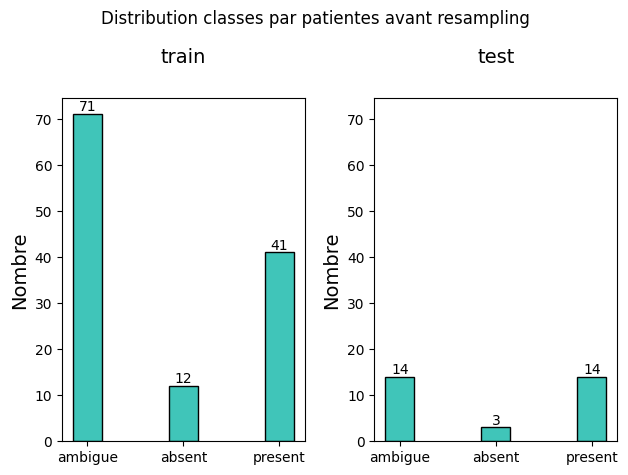

positive data in training: 41
negative data in training: 12
ambiguous data in training: 71

positive data in test: 14
negative data in test: 3
ambiguous data in test: 14
majority class before upsampling: (71, 3)
minority class 1 before upsampling: (12, 3)
minority class 2 before upsampling: (41, 3)
After upsampling
atcd.absenteisme
2.0    71
0.0    71
1.0    71
Name: count, dtype: int64


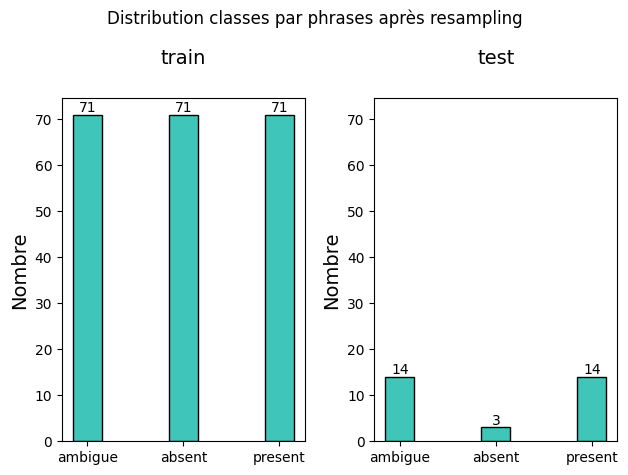

In [5]:
use_resampling = True
balance_method = 'upsampling'       # 'upsampling' or 'downsampling'
if len(features_of_interest) == 1:
    target_feature = features_of_interest[0]
    data_train = pd.merge(X_train, Y_train, on='Anonymisation')

    # Vérifier distribution des classes dans train/val/test
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs = axs.flatten()
    sns.histplot(data=Y_train[target_feature].map({0: 'absent', 1: 'present', 2: 'ambigue'}), shrink=0.3, color='#00B2A2', ax=axs[0])
    axs[0].bar_label(axs[0].containers[0])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Nombre', fontsize=14)
    axs[0].set_title('train', pad=25, fontsize=14)
    sns.histplot(data=Y_test[target_feature].map({0: 'absent', 1: 'present', 2: 'ambigue'}), shrink=0.3, color='#00B2A2', ax=axs[1])
    axs[1].bar_label(axs[1].containers[0])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Nombre', fontsize=14)
    axs[1].set_ylim(axs[0].get_ylim())
    axs[1].set_title('test', pad=25, fontsize=14)
    plt.suptitle('Distribution classes par patientes avant resampling')
    plt.tight_layout()
    plt.show()

    data_positive_train = (Y_train[target_feature] == 1.0).sum()
    data_negative_train = (Y_train[target_feature] == 0.0).sum()
    data_ambiguous_train = (Y_train[target_feature] == 2.0).sum()
    print('positive data in training:', data_positive_train)
    print('negative data in training:', data_negative_train)
    print('ambiguous data in training:', data_ambiguous_train)
    print()
    print('positive data in test:',(Y_test[target_feature] == 1.0).sum())
    print('negative data in test:',(Y_test[target_feature] == 0.0).sum())
    print('ambiguous data in test:',(Y_test[target_feature] == 2.0).sum())

    ### Now the resampling

    # Separate majority and minority classes in training data for upsampling
    if data_positive_train == np.max([data_positive_train, data_negative_train, data_ambiguous_train]):
        data_train_majority = data_train[data_train[target_feature] == 1.0]
        data_train_minority1 = data_train[data_train[target_feature] == 0.0]
        data_train_minority2 = data_train[data_train[target_feature] == 2.0]
    elif data_negative_train == np.max([data_positive_train, data_negative_train, data_ambiguous_train]):
        data_train_majority = data_train[data_train[target_feature] == 0.0]
        data_train_minority1 = data_train[data_train[target_feature] == 1.0]
        data_train_minority2 = data_train[data_train[target_feature] == 2.0]
    elif data_ambiguous_train == np.max([data_positive_train, data_negative_train, data_ambiguous_train]):
        data_train_majority = data_train[data_train[target_feature] == 2.0]
        data_train_minority1 = data_train[data_train[target_feature] == 0.0]
        data_train_minority2 = data_train[data_train[target_feature] == 1.0]
        
    if balance_method=='upsampling':
        
        print("majority class before upsampling:",data_train_majority.shape)
        print("minority class 1 before upsampling:",data_train_minority1.shape)
        print("minority class 2 before upsampling:",data_train_minority2.shape)

        # Upsample minority class 1
        data_train_minority1_upsampled = resample(data_train_minority1, 
                                        replace=True,     # sample with replacement
                                        n_samples= data_train_majority.shape[0],    # to match majority class
                                        random_state=123) # reproducible results
        # Upsample minority class 2
        data_train_minority2_upsampled = resample(data_train_minority2, 
                                        replace=True,     # sample with replacement
                                        n_samples= data_train_majority.shape[0],    # to match majority class
                                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        data_train_upsampled = pd.concat([data_train_majority, data_train_minority1_upsampled, data_train_minority2_upsampled])
        
        # Display new class counts
        print("After upsampling\n",data_train_upsampled[target_feature].value_counts(),sep = "")
        
        data_train = data_train_upsampled.copy()

    # Not recommended since it results in huge data loss - just to test out performance of model with completely balanced data distribution
    elif balance_method=='downsampling':

        minimum_number_of_patients_per_class = np.min([data_positive_train, data_negative_train, data_ambiguous_train])
        
        ### Remove samples from the majority class
        train_original = data_train.copy()
        train_negative = data_train.loc[data_train[target_feature]==0]
        train_positive = data_train.loc[data_train[target_feature]==1]
        train_missing = data_train.loc[data_train[target_feature]==2]
        
        if train_negative.shape[0] > train_positive.shape[0]:
            data_train_majority = train_negative
            data_train_minority = train_positive
        else:
            data_train_majority = train_positive
            data_train_minority = train_negative
        
        train_negative = train_negative.sample(n=minimum_number_of_patients_per_class, replace=False, random_state=1)
        train_positive = train_positive.sample(n=minimum_number_of_patients_per_class, replace=False, random_state=1)
        train_missing = train_missing.sample(n=minimum_number_of_patients_per_class, replace=False, random_state=1)
        
        # Combine majority class with downsampled majority class
        train_downsampled = pd.concat([train_negative, train_positive, train_missing])
        
        data_train = train_downsampled.copy()
    
    X_train = data_train[['Anonymisation', 'Résumé']]
    Y_train = data_train[['Anonymisation', target_feature]].set_index(['Anonymisation'])

    # Vérifier bonne distribution des classes dans train/val/test
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs = axs.flatten()
    sns.histplot(data=Y_train[target_feature].map({0: 'absent', 1: 'present', 2: 'ambigue'}), shrink=0.3, color='#00B2A2', ax=axs[0])
    axs[0].bar_label(axs[0].containers[0])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Nombre', fontsize=14)
    axs[0].set_title('train', pad=25, fontsize=14)
    sns.histplot(data=Y_test[target_feature].map({0: 'absent', 1: 'present', 2: 'ambigue'}), shrink=0.3, color='#00B2A2', ax=axs[1])
    axs[1].bar_label(axs[1].containers[0])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Nombre', fontsize=14)
    axs[1].set_ylim(axs[0].get_ylim())
    axs[1].set_title('test', pad=25, fontsize=14)
    plt.suptitle('Distribution classes par phrases après resampling')
    plt.tight_layout()
    plt.show()

else:
    print('You have more than one feature of interest. You cannot use upsampling')

In [6]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True, max_features=max_vocab, lowercase=False)
X_train_fitted = tfIdfVectorizer.fit_transform(X_train.Résumé)
X_train_fitted_df = pd.DataFrame(X_train_fitted.todense(), columns=tfIdfVectorizer.get_feature_names_out(), index= X_train.Anonymisation)
X_test_fitted = tfIdfVectorizer.transform(X_test.Résumé)
X_test_fitted_df = pd.DataFrame(X_test_fitted.todense(), columns=tfIdfVectorizer.get_feature_names_out(), index= X_test.Anonymisation)

## Algos

### Decision Trees

In [7]:
####################################################################
multilabel_classifier = DecisionTreeClassifier(random_state=42)
labels_MLC = {0:'négatif', 1:'positif', 2:' Non mentionnées'}
multilabel_classifier.fit(X_train_fitted_df, Y_train)
####################################################################

DecisionTreeClassifier(random_state=42)

In [8]:
Y_pred = multilabel_classifier.predict(X_test_fitted_df)
Y_pred = pd.DataFrame(Y_pred, columns=Y_train.columns)
DT_Multi_index, CR_global = rapport_metrics_decision_tree(Y_test, Y_pred)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.33      0.14      0.20        14
         2.0       0.45      0.64      0.53        14

    accuracy                           0.35        31
   macro avg       0.26      0.26      0.24        31
weighted avg       0.35      0.35      0.33        31



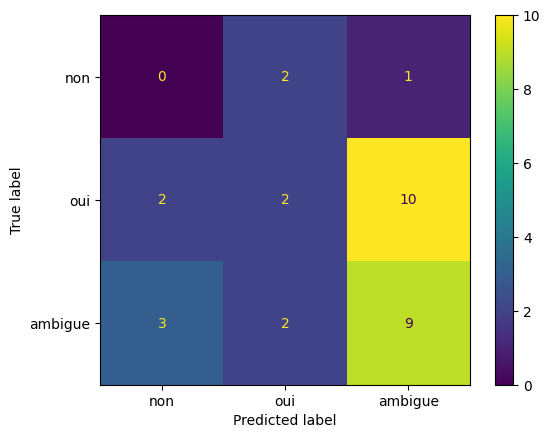

In [9]:
if len(features_of_interest) == 1:
    target_feature = features_of_interest[0]
    print(classification_report(DT_Multi_index[target_feature]['y_true'], DT_Multi_index[target_feature]['y_pred']))
    cm = confusion_matrix(DT_Multi_index[target_feature]['y_true'], DT_Multi_index[target_feature]['y_pred'])
    if len(pd.unique(recueil[target_feature]))==2:
        labels=['non', 'oui']
    else:
        labels=['non', 'oui', 'ambigue']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
else:
    score_decision_tree = evaluate_results_multilabel(DT_Multi_index, CR_global)
    show_best_and_lowest_scores(CR_global, score='f1_score')
    show_best_and_lowest_scores(CR_global, score='recall')
    show_best_and_lowest_scores(CR_global, score='precision')
    show_precision_vs_recall(CR_global)

A faire: Corréler score ML de chaque feature avec score NLP respectif

#### Decision Trees Kfold crossvalidation

              precision    recall  f1-score   support

         0.0       0.10      0.13      0.11        15
         1.0       0.42      0.33      0.37        55
         2.0       0.57      0.61      0.59        85

    accuracy                           0.46       155
   macro avg       0.36      0.36      0.36       155
weighted avg       0.47      0.46      0.46       155



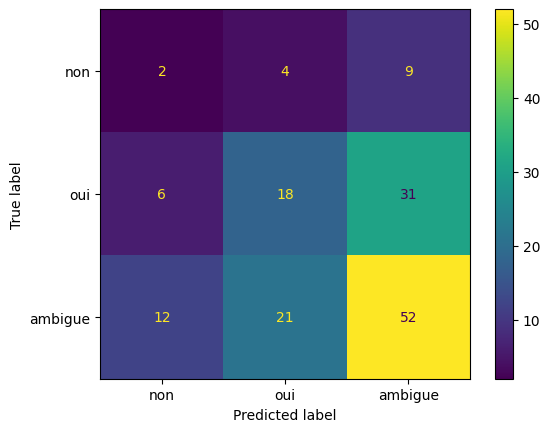

In [10]:
classifier = DecisionTreeClassifier(random_state=42)
Y_pred_folds, classifier = kfold_cv_stratified(X, Y, classifier, max_vocab, nfolds=5)
DT_cv_Multi_index, CR_global_DT_cv = rapport_metrics_decision_tree(Y, Y_pred_folds)
CR_global_DT_cv

if len(features_of_interest) == 1:
    target_feature = features_of_interest[0]
    print(classification_report(DT_cv_Multi_index[target_feature]['y_true'], DT_cv_Multi_index[target_feature]['y_pred']))
    cm = confusion_matrix(DT_cv_Multi_index[target_feature]['y_true'], DT_cv_Multi_index[target_feature]['y_pred'])
    if len(pd.unique(recueil[target_feature]))==2:
        labels=['non', 'oui']
    else:
        labels=['non', 'oui', 'ambigue']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
else:
    score_decision_tree = evaluate_results_multilabel(DT_cv_Multi_index, CR_global_DT_cv)
    show_best_and_lowest_scores(CR_global_DT_cv, score='f1_score')
    show_best_and_lowest_scores(CR_global_DT_cv, score='recall')
    show_best_and_lowest_scores(CR_global_DT_cv, score='precision')
    show_precision_vs_recall(CR_global_DT_cv)

### Random Forests

In [11]:
####################################################################
multilabel_classifier_RFC = RandomForestClassifier(random_state=42, class_weight = "balanced")         # Adjust for the imbalance in class distributions
# labels_MLC = {0:'négatif', 1:'positif', 2:' Non mentionnées'}
multilabel_classifier_RFC.fit(X_train_fitted_df, Y_train)
####################################################################

/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [12]:
Y_pred = multilabel_classifier_RFC.predict(X_test_fitted_df)
Y_pred = pd.DataFrame(Y_pred, columns=Y_train.columns)
RF_Multi_index, CR_global_RF = rapport_metrics_decision_tree(Y_test, Y_pred)
CR_global_RF

atcd.absenteisme
metrics f1_score_0           0.000000
        f1_score_1           0.260870
        f1_score_2           0.514286
        precision_0          0.000000
        precision_1          0.333333
        precision_2          0.428571
        recall_0             0.000000
        recall_1             0.214286
        recall_2             0.642857

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.33      0.21      0.26        14
         2.0       0.43      0.64      0.51        14

    accuracy                           0.39        31
   macro avg       0.25      0.29      0.26        31
weighted avg       0.34      0.39      0.35        31



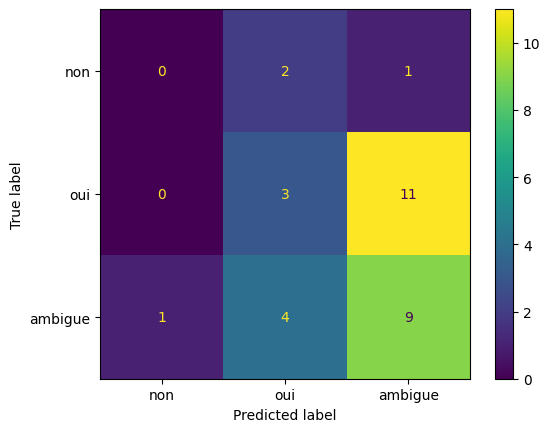

In [13]:
if len(features_of_interest) == 1:
    target_feature = features_of_interest[0]
    print(classification_report(RF_Multi_index[target_feature]['y_true'], RF_Multi_index[target_feature]['y_pred']))
    cm = confusion_matrix(RF_Multi_index[target_feature]['y_true'], RF_Multi_index[target_feature]['y_pred'])
    if len(pd.unique(recueil[target_feature]))==2:
        labels=['non', 'oui']
    else:
        labels=['non', 'oui', 'ambigue']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
else:
    score_decision_tree = evaluate_results_multilabel(RF_Multi_index, CR_global_RF)
    show_best_and_lowest_scores(CR_global_RF, score='f1_score')
    show_best_and_lowest_scores(CR_global_RF, score='recall')
    show_best_and_lowest_scores(CR_global_RF, score='precision')
    show_precision_vs_recall(CR_global_RF)

#### RandomForests Kfold crossvalidation

In [14]:
classifier = RandomForestClassifier(random_state=42, class_weight = "balanced")
Y_pred_folds, classifier = kfold_cv_stratified(X, Y, classifier, max_vocab, nfolds=5)
RF_cv_Multi_index, CR_global_RF_cv = rapport_metrics_decision_tree(Y, Y_pred_folds)
CR_global_RF_cv

/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/nounou/.cache/pypoetry/virtuale

atcd.absenteisme
metrics f1_score_0           0.000000
        f1_score_1           0.179487
        f1_score_2           0.663594
        precision_0          0.000000
        precision_1          0.304348
        precision_2          0.545455
        recall_0             0.000000
        recall_1             0.127273
        recall_2             0.847059

/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        15
         1.0       0.30      0.13      0.18        55
         2.0       0.55      0.85      0.66        85

    accuracy                           0.51       155
   macro avg       0.28      0.32      0.28       155
weighted avg       0.41      0.51      0.43       155



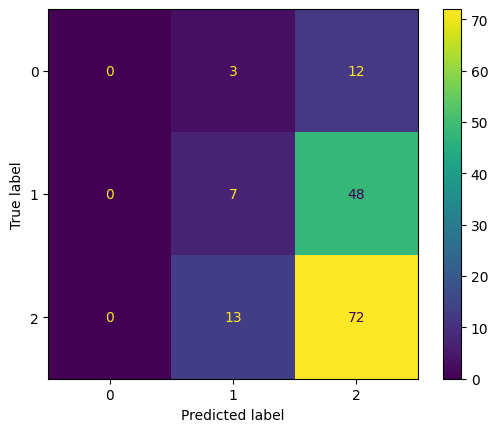

In [15]:
if len(features_of_interest) == 1:
    target_feature = features_of_interest[0]
    print(classification_report(RF_cv_Multi_index[target_feature]['y_true'], RF_cv_Multi_index[target_feature]['y_pred']))
    cm = confusion_matrix(RF_cv_Multi_index[target_feature]['y_true'], RF_cv_Multi_index[target_feature]['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
else:
    score_decision_tree = evaluate_results_multilabel(RF_cv_Multi_index, CR_global_RF_cv)
    show_best_and_lowest_scores(CR_global_RF_cv, score='f1_score')
    show_best_and_lowest_scores(CR_global_RF_cv, score='recall')
    show_best_and_lowest_scores(CR_global_RF_cv, score='precision')
    show_precision_vs_recall(CR_global_RF_cv)

#### Random Forests Hyperparameter Search

In [21]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

# Custom cross-validator class using IterativeStratification
class CustomIterativeStratifiedCV:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, X, y, groups=None):
        mskf = MultilabelStratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return mskf.split(X, y)

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the classifier
classifier = RandomForestClassifier(random_state=42, class_weight="balanced")

# Initialize the custom cross-validator
custom_cv = CustomIterativeStratifiedCV(n_splits=5)

# Initialize GridSearchCV with the custom cross-validator
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, 
                           cv=custom_cv, n_jobs=-1, verbose=2, scoring='f1_weighted')

tfIdfVectorizer=TfidfVectorizer(use_idf=True, max_features=max_vocab, lowercase=False)
X_fitted = tfIdfVectorizer.fit_transform(X.Résumé)
X_fitted_df = pd.DataFrame(X_fitted.todense(), columns=tfIdfVectorizer.get_feature_names_out(), index= X.Anonymisation)

# Exemple de conversion de Y en format multi-étiquette
mlb = MultiLabelBinarizer()
Y_multilabel = mlb.fit_transform(Y.values.reshape(-1, 1))

# Vérifiez le nouveau format de Y
print(Y_multilabel)

# Fit the model
grid_search.fit(X_fitted_df.values, Y_multilabel)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)
print("Best model found: ", best_model)

# Cross-validation predictions using the best model
Y_pred_folds = cross_val_predict(best_model, X_fitted_df.values, Y_multilabel, cv=custom_cv, method='predict')
Y_pred_folds = pd.DataFrame(Y_pred_folds, columns=Y.columns, index=Y.index)

# Compute classification report and confusion matrix
RF_cv_Multi_index, CR_global_RF_cv = rapport_metrics_decision_tree(Y, Y_pred_folds)

# Print the results
print(RF_cv_Multi_index)
print(CR_global_RF_cv)


[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 

/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best model found:  RandomForestClassifier(class_weight='balanced', max_depth=30, random_state=42)


ValueError: Shape of passed values is (155, 3), indices imply (155, 1)

### SVC

In [60]:
CR_global_SVC, SVC_Multi_index, SVC_y_pred, dict_model_svc, SVC_Multi_index_proba = multilabel_multioutput_svc(X_train_fitted_df, X_test_fitted_df, Y_train, Y_test, tfIdfVectorizer)

done


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.50      0.25      0.33        16
         2.0       0.50      0.79      0.61        14

    accuracy                           0.48        31
   macro avg       0.33      0.35      0.31        31
weighted avg       0.48      0.48      0.45        31



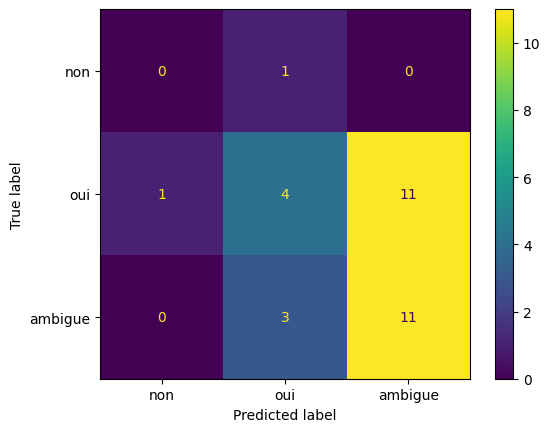

In [61]:
if len(features_of_interest) == 1:
    target_feature = features_of_interest[0]
    print(classification_report(SVC_Multi_index[target_feature]['y_true'], SVC_Multi_index[target_feature]['y_pred']))
    cm = confusion_matrix(SVC_Multi_index[target_feature]['y_true'], SVC_Multi_index[target_feature]['y_pred'])
    if len(pd.unique(recueil[target_feature]))==2:
        labels=['non', 'oui']
    else:
        labels=['non', 'oui', 'ambigue']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
else:
    score_decision_tree = evaluate_results_multilabel(SVC_Multi_index, CR_global_SVC)
    show_best_and_lowest_scores(CR_global_SVC, score='f1_score')
    show_best_and_lowest_scores(CR_global_SVC, score='recall')
    show_best_and_lowest_scores(CR_global_SVC, score='precision')
    show_precision_vs_recall(CR_global_SVC)